In [541]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

np.random.seed(sum(map(ord, "distributions")))


In [2]:
cwd = os.getcwd()
cwd

'C:\\Users\\Renato Aranha\\Documents\\Mestrado\\Foundation_of_DS\\CartolaFCDados'

In [613]:
atletas_all_years = pd.DataFrame()
clubes_all_years = pd.DataFrame()
partidas_all_years = pd.DataFrame()
posicoes_all_years = pd.DataFrame()
scouts_all_years = pd.DataFrame()
status_all_years = pd.DataFrame()


for i in range(2014, 2018):
    
    path_atl = os.path.join(cwd, str(i)+"\\Atletas.csv")    
    path_club = os.path.join(cwd, str(i)+"\\Clubes.csv")    
    path_part = os.path.join(cwd, str(i)+"\\Partidas.csv")    
    path_pos = os.path.join(cwd, str(i)+"\\Posicoes.csv")   
    path_sct = os.path.join(cwd, str(i)+"\\Scouts.csv")    
    path_stts = os.path.join(cwd, str(i)+"\\Status.csv")
    
    atletas = pd.read_csv(path_atl)
    atletas['Ano'] = i
    clubes = pd.read_csv(path_club)
    #clubes['Ano'] = i
    partidas = pd.read_csv(path_part)
    partidas['Ano'] = i
    posicoes = pd.read_csv(path_pos)
    #posicoes['Ano'] = i
    scouts = pd.read_csv(path_sct)
    scouts['Ano'] = i
    status = pd.read_csv(path_stts)
    #status['Ano'] = i
    
    atletas_all_years = atletas_all_years.append(atletas)
    clubes_all_years = clubes_all_years.append(clubes).drop_duplicates()
    partidas_all_years = partidas_all_years.append(partidas)
    posicoes_all_years = posicoes_all_years.append(posicoes).drop_duplicates()
    scouts_all_years = scouts_all_years.append(scouts)
    status_all_years = status_all_years.append(status).drop_duplicates()

# Gerando tabela com partidas

In [706]:
partidas_all_years.head()

,Ano,CasaID,ID,PlacarCasa,PlacarVisitante,Resultado,Rodada,VisitanteID
0,2014,262,179872,0.0,0.0,Empate,1,290
1,2014,266,179873,3.0,0.0,Casa,1,316
2,2014,276,179874,3.0,0.0,Casa,1,263
3,2014,277,179875,1.0,1.0,Empate,1,292
4,2014,293,179876,1.0,0.0,Casa,1,284


In [707]:
clubes_all_years.head()

,ID,Nome,Abreviacao,Slug
0,262,Flamengo,FLA,flamengo
1,263,Botafogo,BOT,botafogo
2,264,Corinthians,COR,corinthians
3,265,Bahia,BAH,bahia
4,266,Fluminense,FLU,fluminense


In [713]:
def gera_partidas_com_clubes(partidas_all_years, clubes_all_years):
    partidas_all_years = partidas_all_years.merge(clubes_all_years[['ID','Abreviacao']], how='inner', left_on='CasaID',\
                         right_on='ID')
    partidas_all_years = partidas_all_years.merge(clubes_all_years[['ID','Abreviacao']], how='inner', left_on='VisitanteID',\
                         right_on='ID')
    partidas_all_years = partidas_all_years.drop(labels=['ID_y','ID'], axis = 1)
    partidas_com_clubes = partidas_all_years.rename(columns={'ID_x':'ID_partida','Abreviacao_x':'abrev_clube_casa','Abreviacao_y':'abrev_clube_fora'})
    return partidas_com_clubes

def remove_erros_SPO(partidas_com_clubes):
    a = partidas_com_clubes.copy().drop_duplicates()
    temp = pd.DataFrame(a.groupby(['ID_partida'])['ID_partida'].count())
    temp2 = temp[temp.ID_partida == 2]
    
    a = a[(a.ID_partida.isin(temp2.index))]
    a = a[(a.abrev_clube_casa == 'SPO') | (a.abrev_clube_fora == 'SPO')]
    
    final = partidas_com_clubes[~partidas_com_clubes.index.isin(a.index)]
    partidas_com_clubes_corrigido = final.drop_duplicates()
    
    return partidas_com_clubes_corrigido

def adiciona_pontuacao(partidas_com_clubes_corrigido):
    def pts_casa(casa, fora):
        if casa > fora:
            a = 3
        elif casa < fora:
            a = 0
        else:
            a = 1
        return a

    def pts_fora(casa, fora):
        if casa > fora:
            a = 0
        elif casa < fora:
            a = 3
        else:
            a = 1
        return a
    
    a = partidas_com_clubes_corrigido.copy().drop_duplicates().reset_index()
    a['pts_casa'] = a.apply(lambda x: pts_casa(x.PlacarCasa, x.PlacarVisitante), axis=1)
    a['pts_fora'] = a.apply(lambda x: pts_fora(x.PlacarCasa, x.PlacarVisitante), axis=1)
    
    partidas_com_pontuacao = a
    
    return partidas_com_pontuacao

def gera_classificacao(partidas_com_pontuacao):
    b = partidas_com_pontuacao.copy()
    casa = pd.DataFrame(b.groupby(['Ano','abrev_clube_casa'])['pts_casa'].sum())
    fora = pd.DataFrame(b.groupby(['Ano','abrev_clube_fora'])['pts_fora'].sum())
    tabela = pd.concat([casa, fora], axis=1)
    tabela['pts_total'] = tabela.pts_casa + tabela.pts_fora
    tabela = tabela.reset_index().sort_values(by=['Ano','pts_total'], ascending = [True, False])
    return tabela

In [715]:
partidas_com_clubes = gera_partidas_com_clubes(partidas_all_years, clubes_all_years).drop_duplicates()

partidas_com_clubes_corrigido = remove_erros_SPO(partidas_com_clubes)

partidas_com_pontuacao = adiciona_pontuacao(partidas_com_clubes_corrigido)

tabela = gera_classificacao(partidas_com_pontuacao)

tabela

,Ano,abrev_clube_casa,pts_casa,pts_fora,pts_total
8,2014,CRU,47,33,80
17,2014,SAO,39,31,70
6,2014,COR,42,27,69
14,2014,INT,45,24,69
2,2014,CAM,41,21,62
11,2014,FLU,39,22,61
13,2014,GRE,40,21,61
3,2014,CAP,35,19,54
16,2014,SAN,33,20,53
10,2014,FLA,35,17,52


In [717]:
partidas_com_clubes_corrigido

,Ano,CasaID,ID_partida,PlacarCasa,PlacarVisitante,Resultado,Rodada,VisitanteID,abrev_clube_casa,abrev_clube_fora
0,2014,262,179872,0.0,0.0,Empate,1,290,FLA,GOI
2,2015,262,190387,4.0,1.0,Casa,34,290,FLA,GOI
4,2014,266,180066,2.0,0.0,Casa,13,290,FLU,GOI
6,2015,266,190326,2.0,0.0,Casa,28,290,FLU,GOI
8,2014,276,180145,3.0,0.0,Casa,31,290,SAO,GOI
10,2015,276,190233,0.0,3.0,Visitante,19,290,SAO,GOI
12,2014,277,179998,2.0,0.0,Casa,25,290,SAN,GOI
14,2015,277,190355,3.0,1.0,Casa,31,290,SAN,GOI
16,2014,293,180179,1.0,0.0,Casa,37,290,CAP,GOI
18,2015,293,190261,3.0,0.0,Casa,21,290,CAP,GOI


In [719]:
partidas_com_clubes_corrigido.to_csv('partidas_all_years.csv', sep='\t')

# Gerando tabela com atletas

In [13]:
atletas_all_years.head()

,ID,Apelido,ClubeID,PosicaoID,Ano
0,80583,Lucas Lima,277,4,2014
1,72079,Bruno Cortez,288,2,2014
2,86189,Mosquito,293,5,2014
3,68938,Giovanni Augusto,316,4,2014
4,68974,Marcão,316,5,2014


In [14]:
clubes_all_years.head()

,ID,Nome,Abreviacao,Slug
0,262,Flamengo,FLA,flamengo
1,263,Botafogo,BOT,botafogo
2,264,Corinthians,COR,corinthians
3,265,Bahia,BAH,bahia
4,266,Fluminense,FLU,fluminense


In [15]:
posicoes_all_years

,ID,Nome,Abreviacao
0,1,Goleiro,GOL
1,2,Lateral,LAT
2,3,Zagueiro,ZAG
3,4,Meia,MEI
4,5,Atacante,ATA
5,6,Técnico,TEC


In [16]:
atletas_all_years = atletas_all_years.merge(clubes_all_years[['ID','Abreviacao','Nome']], how='inner', left_on='ClubeID',\
                         right_on='ID')

atletas_all_years = atletas_all_years.merge(posicoes_all_years[['ID','Abreviacao']], how='inner', left_on='PosicaoID',\
                         right_on='ID')

atletas_all_years = atletas_all_years.drop(labels=['ID_y','ID'], axis = 1)

In [17]:
atletas_all_years = atletas_all_years.rename(columns={'ID_x':'ID_jogador','Nome':'nome_clube','Abreviacao_x':'abrev_clube',\
                                                     'Abreviacao_y':'posicao'})

In [18]:
atletas_all_years.head()

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
0,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
1,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
2,88002,Serginho,277,4,2014,SAN,Santos,MEI
3,88002,Serginho,277,4,2014,SAN,Santos,MEI
4,70132,Alan Santos,277,4,2014,SAN,Santos,MEI


In [19]:
atletas_all_years.to_csv('atletas_all_years.csv', sep='\t')

# Exploratory Data Analysis

In [31]:
atletas_all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7690 entries, 0 to 7689
Data columns (total 8 columns):
ID_jogador     7690 non-null int64
Apelido        7690 non-null object
ClubeID        7690 non-null int64
PosicaoID      7690 non-null int64
Ano            7690 non-null int64
abrev_clube    7690 non-null object
nome_clube     7690 non-null object
posicao        7690 non-null object
dtypes: int64(4), object(4)
memory usage: 540.7+ KB


In [21]:
partidas_all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5124 entries, 0 to 5123
Data columns (total 10 columns):
Ano                 5124 non-null int64
CasaID              5124 non-null int64
ID_partida          5124 non-null int64
PlacarCasa          5120 non-null float64
PlacarVisitante     5120 non-null float64
Resultado           3892 non-null object
Rodada              5124 non-null int64
VisitanteID         5124 non-null int64
abrev_clube_casa    5124 non-null object
abrev_clube_fora    5124 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 440.3+ KB


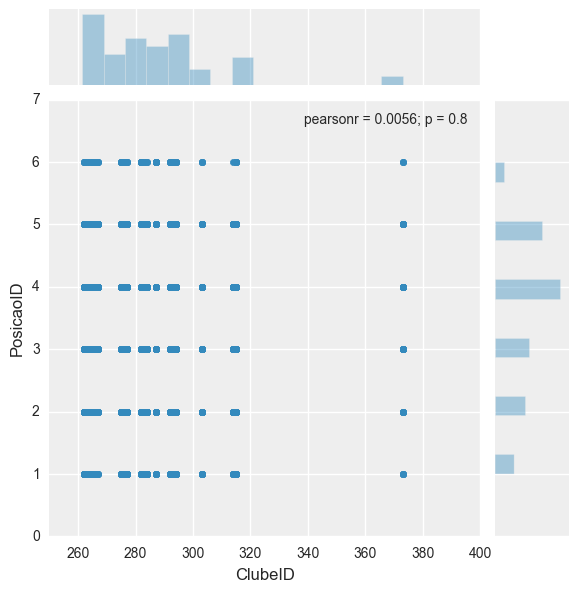

In [88]:
sns.jointplot(x="ClubeID", y="PosicaoID", data=atletas_all_years[atletas_all_years.Ano == 2017], size=6, xlim=[250,400]);

In [89]:
list(set(atletas_all_years.dtypes.tolist()))

[dtype('int64'), dtype('O')]

In [90]:
df_num = atletas_all_years.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,ID_jogador,ClubeID,PosicaoID,Ano
0,80583,277,4,2014
1,80583,277,4,2014
2,88002,277,4,2014
3,88002,277,4,2014
4,70132,277,4,2014


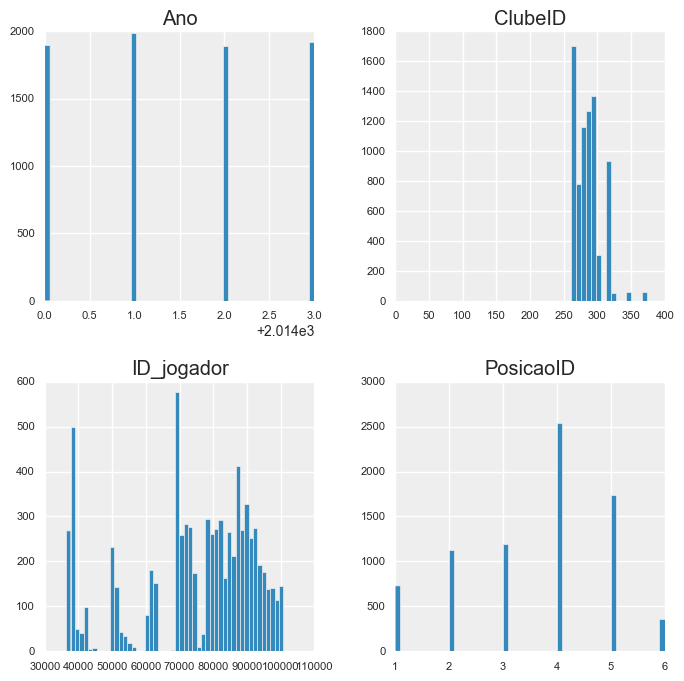

In [105]:
atletas_all_years.hist(figsize=(8, 8), bins=50, xlabelsize=8, ylabelsize=8);

In [104]:
atletas_all_years.sample(10).sort_values("ID_jogador")

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
1413,38928,Dudu Cearense,263,4,2016,BOT,Botafogo,MEI
2436,41387,Eduardo Costa,314,4,2015,AVA,Avaí,MEI
5553,68928,Rafael,283,1,2017,CRU,Cruzeiro,GOL
5786,79066,Alex Muralha,262,1,2017,FLA,Flamengo,GOL
2348,82680,Nathan Índio,303,4,2015,PON,Ponte Preta,MEI
4400,86748,Breno,284,2,2014,GRE,Grêmio,LAT
2011,87226,Fabiano,264,4,2014,COR,Corinthians,MEI
2669,91866,Zé Ivaldo,293,3,2016,CAP,Atlético-PR,ZAG
7596,97454,Edinan,303,5,2017,PON,Ponte Preta,ATA
3423,98945,Derlan,266,3,2017,FLU,Fluminense,ZAG
